# Experiment: Linear Scaling Learning Rate with Gradual Warmup

Our goal is to experiment with larger minibatch sizes and learning rates to see if training time can be reduced without sacrificing predictive performance. Idea from Bag of Tricks for "Image Classification with Convolutional Neural Networks" by Tong et al. (2018) and "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour" by Goyal et al. (2018).

# DSA4212 Assignment 1: Starter Kit

In [ ]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
import math

In [ ]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)



All ok -- code is running on a Google Colab


In [ ]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-ba73c9cb-4a58-0909-447f-1bfb8f33153b)
Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
12G


# Connect to Google Drive & Load data

In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
# goto to data folder -- you may need to change this location
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train_all = np.load("assignment_1_train.npz")
data_test = np.load("assignment_1_test.npz")

X_train_all = data_train_all["img"].astype(np.float32) / 255.   # set pixel intensities to [0,1]
X_test = data_test["img"].astype(np.float32) / 255.
Y_train_all = data_train_all["label"].astype(int)
Y_test = data_test["label"].astype(int)

_,H,W,C = X_train_all.shape
print(f"Img Shape: {H}x{W}x{C}")

Img Shape: 128x128x3


In [ ]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train_all))
np.random.shuffle(indices_shuffled)
X_train_all = X_train_all[indices_shuffled]
Y_train_all = Y_train_all[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_test))
np.random.shuffle(indices_shuffled)
X_test = X_test[indices_shuffled]
Y_test = Y_test[indices_shuffled]

In [ ]:
sz_train = X_train_all.size * X_train_all.itemsize / 2.**30
sz_val = X_test.size * X_test.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 1.70 Go
Validaton Set Size: 0.71 Go


# Split Train / Validation / Test

The test set can only be used for the final evaluation of the model: one cannot use the test set when tuning the models. Consequently, we are going to split `X_train_all` into a train-set and a validation-set.

In [ ]:
len_train_all = len(X_train_all)
len_train = int(0.8 * len_train_all)
len_val = len_train_all - len_train
len_tets = len(X_test)

X_train = X_train_all[:len_train]
Y_train = Y_train_all[:len_train]

X_val = X_train_all[len_train:]
Y_val = Y_train_all[len_train:]

# Sanity checks
Let us make sure that the data is all ok

Text(0.5, 1.0, 'Pixel Intensity')

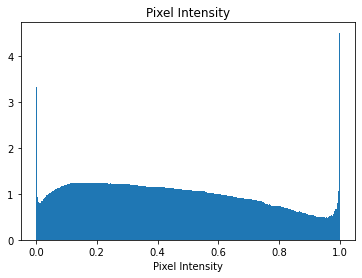

In [ ]:
# histogram of pixel intensities
_ = plt.hist(X_train.ravel(), bins=256, density=True)
plt.xlabel("Pixel Intensity")
plt.title("Pixel Intensity")

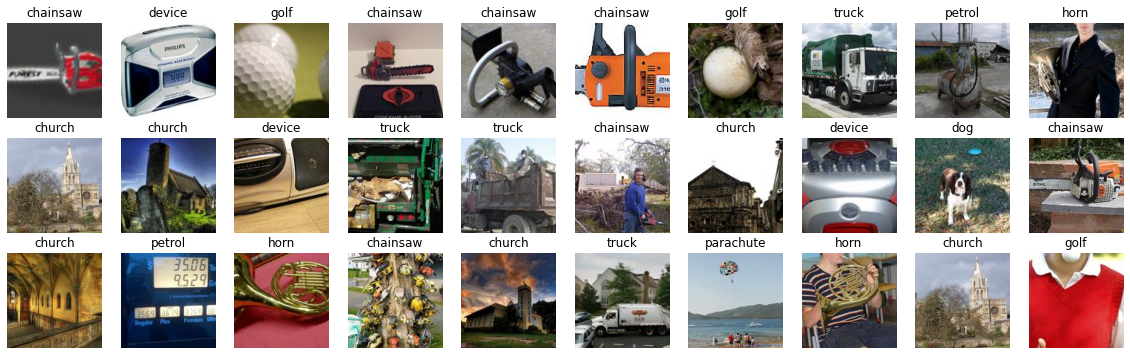

In [ ]:
# train set:: sanity check
# plt a few random images in the trainset as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_train))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_train[index,:,:,:])
    plt.title(class_names[Y_train[index]])

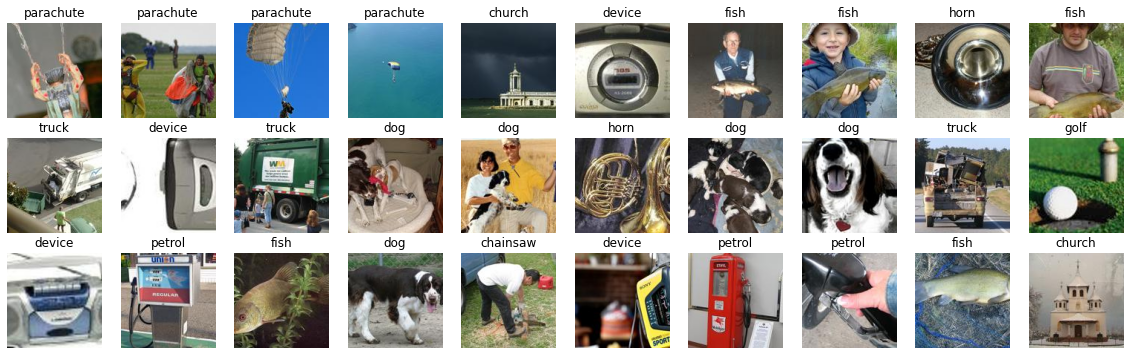

In [ ]:
# validation set:: sanity check
# plt a few images as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_val))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_val[index,:,:,:])
    plt.title(class_names[Y_val[index]])

In [ ]:
# load FLAX and install it if not installed already
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

import flax
from flax import linen as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 11.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [ ]:
import jax
import jax.numpy as jnp
from typing import Any, Sequence

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

In [ ]:
class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class SimpleCNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.elu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME', name=f'layers_{i}_1')(x) )
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas

In [ ]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(n_filters=[32,64, 128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 94k


In [ ]:
@jax.jit
def loss(params, x, y):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = net.apply(params, x)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [ ]:
@jax.jit
def prediction_class(params, x):
  """ make a prediction """
  pred = net.apply(params, x)
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [ ]:
# put data to GPU
X_train = jax.device_put(X_train)
X_val = jax.device_put(X_val)


# Experiment 1: Base Case

In [ ]:
# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

#define the SGD optimizer with an lr of 0.1 (following the paper)
optimizer = optax.sgd(learning_rate=0.1)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

In [ ]:
niter = 1000
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )
print(f'total time taken:{time.time()-time_start}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Time:0.1sec 	 Epoch:0.1 	 Loss [2.30 / 2.30] 	 Accuracy Train/Valid: [10.94% / 10.35%]
Time:4.5sec 	 Epoch:3.5 	 Loss [2.20 / 2.20] 	 Accuracy Train/Valid: [30.86% / 27.73%]
Time:8.8sec 	 Epoch:7.0 	 Loss [2.07 / 2.10] 	 Accuracy Train/Valid: [34.38% / 28.71%]
Time:13.1sec 	 Epoch:10.4 	 Loss [1.95 / 2.03] 	 Accuracy Train/Valid: [39.26% / 31.25%]
Time:17.5sec 	 Epoch:13.8 	 Loss [1.86 / 1.93] 	 Accuracy Train/Valid: [41.02% / 38.48%]
Time:21.9sec 	 Epoch:17.3 	 Loss [1.90 / 1.93] 	 Accuracy Train/Valid: [42.58% / 34.96%]
Time:26.4sec 	 Epoch:20.7 	 Loss [1.74 / 1.83] 	 Accuracy Train/Valid: [44.73% / 39.65%]
Time:30.8sec 	 Epoch:24.2 	 Loss [1.62 / 1.77] 	 Accuracy Train/Valid: [46.68% / 39.26%]
Time:35.2sec 	 Epoch:27.6 	 Loss [1.61 / 1.73] 	 Accuracy Train/Valid: [47.27% / 41.02%]
Time:39.6sec 	 Epoch:31.1 	 Loss [1.62 / 1.75] 	 Accuracy Train/Valid: [47.27% / 42.19%]
Time:44.0sec 	 Epoch:34.5 	 Loss [1.59 / 1.65] 	 Accuracy Train/Valid: [50.20% / 46.09%]
Time:48.4sec 	 Epoch:37.9 	

In [ ]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(params, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(params, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/7 [00:00<?, ?it/s]

Final Test Accuracy: 55.8%


#Experiment 2: With Linear Scaling Learning Rate and Learning Rate Warmup

We follow the learning rate schedule as follows in Bag of Tricks for Image Classification with Convolutional Neural Networks by Tong et al (2018).

We increase the batch size to four time the original value and hence multiply the learning rate by 4.

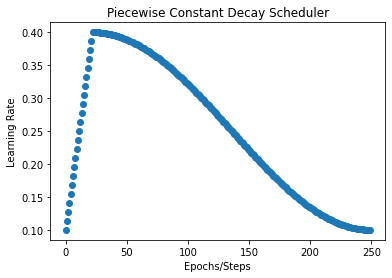

In [ ]:
#every 5 steps add 0.1
total_steps = 250
#Defining the learning rate scheduler
warmup_cosine_decay_scheduler = optax.warmup_cosine_decay_schedule(init_value=0.1, peak_value=0.4,
                                                                   warmup_steps=22,
                                                                   decay_steps=total_steps, end_value=0.1)
#Plot of learning rate at each k
lrs = [warmup_cosine_decay_scheduler(i) for i in range(total_steps)]

plt.scatter(range(250), lrs)
plt.title("Piecewise Constant Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps");

In [ ]:
#Defining new params and optimizers
params_new = copy.deepcopy(params_init)
optimizer_new = optax.sgd(learning_rate=warmup_cosine_decay_scheduler)
opt_state_new = optimizer_new.init(params_new)

In [ ]:
#With batch size quadrupled, niter would be divided by 4 to maintain same number of epochs
niter = 250
batch_size = 2048

# save the train loss
loss_train_history_new = []
loss_train_history_time_new = []

# save the validation loss
loss_val_history_new = []
loss_val_history_time_new = []

# save accuracies
accuracies_history_new = []
accuracies_history_time_new = []

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params_new, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 12 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params_new, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params_new, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history_new.append([acc_train, acc_val])
    accuracies_history_time_new.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params_new, X_val[:N], Y_val[:N])
    loss_val_history_new.append( loss_val )
    loss_val_history_time_new.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state_new = optimizer_new.update(grads, opt_state_new, params_new)
  # apply the "update mechanism"
  params_new = optax.apply_updates(params_new, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time_new.append( time_elapsed )
  loss_train_history_new.append( loss_train.item() )
print(f'total time taken:{time.time()-time_start}')

  0%|          | 0/250 [00:00<?, ?it/s]

Time:0.2sec 	 Epoch:0.3 	 Loss [2.30 / 2.30] 	 Accuracy Train/Valid: [10.94% / 10.35%]
Time:4.3sec 	 Epoch:3.6 	 Loss [2.26 / 2.26] 	 Accuracy Train/Valid: [24.61% / 23.83%]
Time:8.4sec 	 Epoch:6.9 	 Loss [2.16 / 2.18] 	 Accuracy Train/Valid: [31.25% / 27.93%]
Time:12.6sec 	 Epoch:10.2 	 Loss [2.07 / 2.12] 	 Accuracy Train/Valid: [33.01% / 28.52%]
Time:16.8sec 	 Epoch:13.5 	 Loss [2.03 / 2.07] 	 Accuracy Train/Valid: [36.33% / 28.52%]
Time:21.0sec 	 Epoch:16.8 	 Loss [1.98 / 2.05] 	 Accuracy Train/Valid: [34.77% / 29.69%]
Time:25.3sec 	 Epoch:20.1 	 Loss [2.02 / 2.08] 	 Accuracy Train/Valid: [34.77% / 30.08%]
Time:29.7sec 	 Epoch:23.4 	 Loss [1.82 / 1.91] 	 Accuracy Train/Valid: [44.92% / 35.55%]
Time:34.1sec 	 Epoch:26.7 	 Loss [1.82 / 1.91] 	 Accuracy Train/Valid: [42.58% / 35.74%]
Time:38.4sec 	 Epoch:30.0 	 Loss [1.72 / 1.83] 	 Accuracy Train/Valid: [43.95% / 37.89%]
Time:42.7sec 	 Epoch:33.3 	 Loss [1.71 / 1.80] 	 Accuracy Train/Valid: [44.14% / 37.11%]
Time:47.0sec 	 Epoch:36.6 	

In [ ]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(params_new, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(params_new, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/1 [00:00<?, ?it/s]

Final Test Accuracy: 47.9%


#Visualisations

Experiment 1 refers to the base case, while experiment 2 refers to the case where minibatch sized is increased and the learning rate is scaled accordingly

Text(0.5, 1.0, 'Training Loss Comparison')

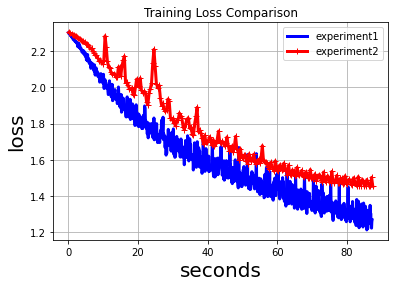

In [ ]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="experiment1")
plt.plot(loss_train_history_time_new, loss_train_history_new, "r-+", lw = 3, label="experiment2")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()
plt.title("Training Loss Comparison")

Text(0.5, 1.0, 'Training Accuracy Comparison')

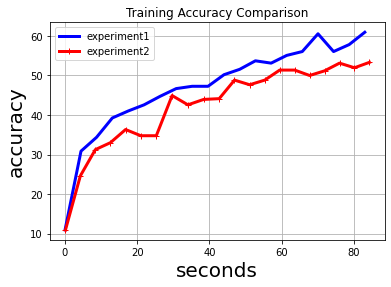

In [ ]:
accuracies_history = np.array(accuracies_history)
accuracies_history_new = np.array(accuracies_history_new)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="experiment1")
plt.plot(accuracies_history_time_new, accuracies_history_new[:,0], "r-+", lw = 3, label="experiment2")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.grid(True)
plt.legend()
plt.title("Training Accuracy Comparison")

Text(0.5, 1.0, 'Validation Loss Comparison')

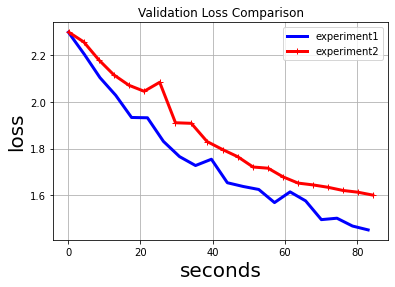

In [ ]:
plt.plot(loss_val_history_time, loss_val_history, "b-", lw = 3, label="experiment1")
plt.plot(loss_val_history_time_new, loss_val_history_new, "r-+", lw = 3, label="experiment2")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()
plt.title("Validation Loss Comparison")


Text(0.5, 1.0, 'Validation Accuracy Comparison')

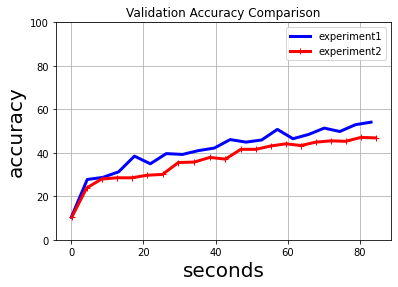

In [ ]:
plt.plot(accuracies_history_time, accuracies_history[:,1], "b-", lw = 3, label="experiment1")
plt.plot(accuracies_history_time_new, accuracies_history_new[:,1], "r-+", lw = 3, label="experiment2")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()
plt.title("Validation Accuracy Comparison")

## Conclusion
Evidently, there was little reduction in training time. In "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour" by Goyal et al. (2018), they were able to increase the number of GPUs they have to allow for faster processing at higher minibatch sizes.

The predictive performance on both training and validation set is also worse off when using a minibatch 4x the size. Initial fluctuations in training loss for higher minibatch sizes were probably a result of high learning rates.